I want code that I can reuse for arbitrary jurisdictions that are contained in the John Hopkins data. Those 3 fields are Admin2, Province_State, and Country_Region.

In [26]:
# import libraries
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [27]:
def data_merge(arg_dict):
    """Read files off disk and merge those 2 files"""
    
    # Read in dfs
    df = pd.read_csv(arg_dict['file_name_1'])
    country_codes_df = pd.read_csv(arg_dict['file_name_2'])
    
    # Lets rename the 3 letter code column
    country_codes_df.rename({'ISO3166-1-Alpha-3': 'Alpha_3'}, axis=1, inplace =True)
    
    # We only want Country_Region and Alpha_3
    country_codes_df = country_codes_df[['Country_Region', 'Alpha_3']]
    
    # Merge the 2 dfs
    df_cc = df.merge(country_codes_df)
    
    return df_cc


In [28]:
def restrict_column_place(df, arg_dict):
    """Take the input df and return a df that is restricted to column (feature) and place"""
    
    # Put df on a diet
    df = df[['Date_', arg_dict['feature'], arg_dict['dependent_variable']]] 
    
    # Restrict to place
    df = df[df[arg_dict['feature']] == arg_dict['place']] 
    
    # Might have an incorrect place name
    if len(df) > 0:
        
        # Create a groupby on Date_. 
        # Since we only have the 'place' left we have the df we want in sorted order with Date_ as the index.
        df_gb = df.groupby('Date_').sum()
        
    else:
        print('We have a challenge. df_gb is empty. def restrict_columnn_place')
        return df_gb
        
    return df_gb


In [29]:
def data_clean(df, arg_dict):
    """There is some data cleaning required"""
    
    # Nulls are not a challenge. However, there are parts of this dataset where deaths are 0
    df = df[df[arg_dict['dependent_variable']] != 0]
    
    return df

In [30]:
def load_prepare(df, arg_dict):
    """Load the data, difference, and return series"""
    
    # difference the data using shift
    new_col = "Daily_" + arg_dict['dependent_variable']
    df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()

    # return the series, except for first row which is NaN
    return df[new_col][1:]


In [32]:
def check_stationary(stationary, arg_dict):
    """Look at some statistics and graphs to see if the dataset is now stationary"""

    # check if stationary
    result = adfuller(stationary)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # plot differenced data
    stationary.plot()
    plt.ylabel(arg_dict['dependent_variable'])
    plt.title('Differenced Data')
    plt.show();

    # save
    stationary.to_csv(r'data/stationary.csv')
    

In [33]:
def acf_pacf_plots(series):
    """ACF and PACF plots of the time series"""

    plt.figure(figsize=(16,6))
    plt.subplot(211)
    plot_acf(series, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(series, ax=plt.gca())
    plt.show()

In [34]:
def driver(arg_dict):
    """This is the main driver program that pushes the program thru its execution"""
    
    # Start the data preparation by merging the 2 files
    df = data_merge(arg_dict)
    
    # Restrict the resulting df to the column (feature) and place that you want
    df = restrict_column_place(df, arg_dict)  
    
    # Clean up the data
    df = data_clean(df, arg_dict)
    
    # Load the data and create a stationary dataset
    stationary = load_prepare(df, arg_dict)
    
    # Check if stationary, print, statistics and plot the differenced data
    check_stationary(stationary, arg_dict)
    
    # ACF and PACF plots of the time series
    series = df[arg_dict['dependent_variable']] # These are the original values.
    acf_pacf_plots(series)
    
    return df


ADF Statistic: -1.697985
p-value: 0.432151
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


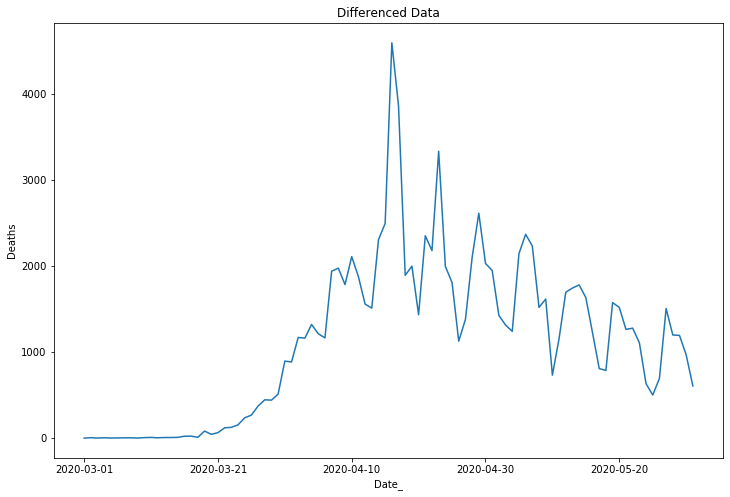

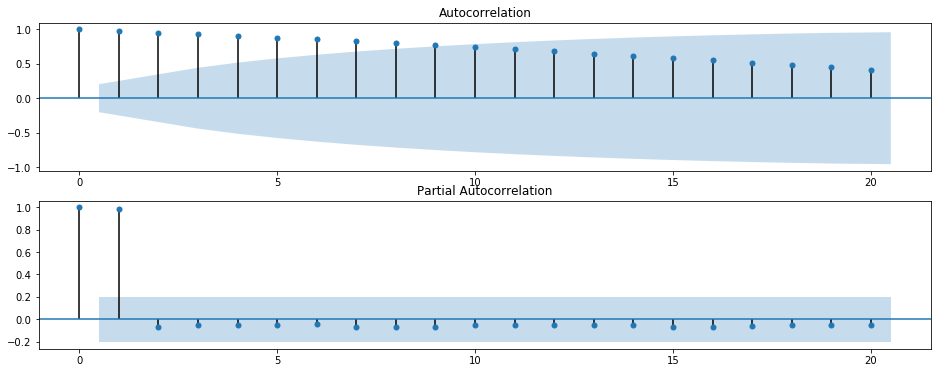

In [35]:
if __name__ == '__main__':
    
    # Prepare arguments for driver
    arg_dict = {'file_name_1': r'data\all_df.csv',
                'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
                'feature': 'Alpha_3',
                'place': 'USA',
                'dependent_variable': 'Deaths'}
    
    # Start driver
    df = driver(arg_dict)
    